In [1]:
import pandas as pd
import numpy as np
import os
from data_utils import build_pulse, filter_pulse, basic_processing
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.iolib.summary2 import summary_col
from statsmodels.iolib.smpickle import load_pickle
import geopandas as gpd

In [2]:
# Periods: https://www.census.gov/programs-surveys/household-pulse-survey/datasets.html
week_start = 34
week_end = 39

In [3]:
file_path = f"processed_data/{week_start}_{week_end}_pulse.csv"
if os.path.exists(file_path):
    df = pd.read_csv(file_path)
else:
    df = build_pulse(week_start, week_end)
    df = filter_pulse(df, verbose=True)
    df = basic_processing(df, trim=False)
    df.to_csv(file_path, index=False)

In [4]:
state_shapes = gpd.read_file("https://www2.census.gov/geo/tiger/TIGER2022/STATE/tl_2022_us_state.zip")

In [5]:
df_ = df

In [6]:
# Basic CTC Eligibility
has_kids = df_["THHLD_NUMKID"] > 0
income_under_150k = (df_['INCOME'] < 7)
income_under_75k = (df_['INCOME'] < 5)
income_under_100k = (df_['INCOME'] < 6)
married_or_widowed = (df_['MS'] == 1) | (df_['MS'] == 2)
# Retrieval question
df["Received_CTC"] = (df['CTC_YN'] == 1).astype(int)
# Key Vars
eligible = (has_kids)
df_["Eligible"] = (eligible).astype(int)
df_['Post'] = ((df_["WEEK"] > 33) & (df_["WEEK"] < 40)).astype(int)

In [7]:
eligs = [has_kids,
(has_kids & income_under_150k),
(has_kids & income_under_150k & married_or_widowed),
(has_kids & income_under_150k & married_or_widowed) | (has_kids & income_under_100k & ~married_or_widowed),
]
names = [
    'Has Kids',
    '& Inc<150k',
    '& Inc<150k & Married (Mar)',
    '& [(Inc<150k & Mar) Or (Inc<100k & not Mar)]',
]
outcomes = []
for elig in eligs:
    outcomes.append(
    df_[elig]["Received_CTC"].value_counts(normalize=True)
    )
outcome_table = round(pd.concat(outcomes, axis=1), 4)
outcome_table.index = ['True Positive', 'False Positive']
outcome_table.columns = names
outcome_table

,Has Kids,& Inc<150k,& Inc<150k & Married (Mar),& [(Inc<150k & Mar) Or (Inc<100k & not Mar)]
True Positive,0.6335,0.6612,0.7011,0.6661
False Positive,0.3665,0.3388,0.2989,0.3339


In [26]:
print(outcome_table.T.to_csv())

,True Positive,False Positive
Has Kids,0.6335,0.3665
& Inc<150k,0.6612,0.3388
& Inc<150k & Married (Mar),0.7011,0.2989
& [(Inc<150k & Mar) Or (Inc<100k & not Mar)],0.6661,0.3339



In [27]:
print(outcome_table.T.to_latex())

\begin{tabular}{lrr}
\toprule
{} &  True Positive &  False Positive \\
\midrule
Has Kids                                     &         0.6335 &          0.3665 \\
\& Inc<150k                                   &         0.6612 &          0.3388 \\
\& Inc<150k \& Married (Mar)                   &         0.7011 &          0.2989 \\
\& [(Inc<150k \& Mar) Or (Inc<100k \& not Mar)] &         0.6661 &          0.3339 \\
\bottomrule
\end{tabular}



C:\Users\peteramerkhanian\AppData\Local\Temp\ipykernel_12708\913065972.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(outcome_table.T.to_latex())


In [28]:
income_dict = {1: '<$25k',
2: '$25k - $35k',
3: '$35k - $50k',   
4: '$50k - $75k',   
5: '$75k - $100k',   
6: '$100k - $150k ',  
7: '$150k - $200k',
8: '>$200k '}

In [29]:
df[has_kids].groupby("Income").apply(lambda x: np.average(x.Received_CTC, weights=x.Household_Weight))

Income
1    0.545373
2    0.635853
3    0.647920
4    0.670807
5    0.682861
6    0.688291
7    0.629433
8    0.486879
dtype: float64

In [30]:
# ctc_by_income = round(df[has_kids]
# .assign(Weighted_CTC=lambda x: x.Received_CTC * x.Household_Weight)
# .groupby("Income")[["Household_Weight", "Weighted_CTC"]]
# .agg(np.sum)
# .assign(Percent_CTC=lambda x: x.Weighted_CTC/x.Household_Weight)
# [["Percent_CTC"]].rename(columns={'Percent_CTC': "Proportion of Households with Children Receiving Advance CTC"})
# , 2
# )
# ctc_by_income

In [31]:
# print(ctc_by_income.to_latex())

In [32]:
subset = df[has_kids].query("Received_CTC == 1")

In [33]:
weights_matrix = np.vstack([subset['Household_Weight'].values]* 3).T

In [34]:
subset[['KIDS_LT5Y', 'KIDS_5_11Y', 'KIDS_12_17Y']] = subset[['KIDS_LT5Y', 'KIDS_5_11Y', 'KIDS_12_17Y']].replace({-99: 0})

In [35]:
subset["Weighted_KidsUnder5"] = subset['KIDS_LT5Y'] * subset['Household_Weight']

In [36]:
subset.groupby("Income").apply(lambda x: np.average(x.KIDS_LT5Y, weights=x.Household_Weight))

Income
1    0.356388
2    0.350196
3    0.387608
4    0.372000
5    0.414091
6    0.376365
7    0.355569
8    0.381673
dtype: float64

In [37]:
subset["Weighted_Kids"] = subset['Number_of_kids'] * subset['Household_Weight']

In [54]:
subset["Monthly_Benefit"] =  subset['Number_of_kids'] *250 + subset['KIDS_LT5Y'] * 50

In [57]:
first_stage_table =pd.concat(
    [df[has_kids].groupby("Income").apply(lambda x: np.average(x.Received_CTC, weights=x.Household_Weight)),
        subset.groupby("Income").apply(lambda x: np.average(x.Monthly_Benefit, weights=x.Household_Weight)),
        subset.groupby("Income").apply(lambda x: np.average(x.Number_of_kids, weights=x.Household_Weight)),
    subset.groupby("Income").apply(lambda x: np.average(x.KIDS_LT5Y, weights=x.Household_Weight))
    ],
axis=1)
first_stage_table.columns = ["Received CTC | Has Kids", "Average Estimated Monthly Benefit", "Average # Kids", "Has Kids Under 5"]
first_stage_table.index = income_dict.values()

In [60]:
print(round(first_stage_table, 2).to_csv())

,Received CTC | Has Kids,Average Estimated Monthly Benefit,Average # Kids,Has Kids Under 5
<$25k,0.55,521.21,2.01,0.36
$25k - $35k,0.64,527.32,2.04,0.35
$35k - $50k,0.65,531.64,2.05,0.39
$50k - $75k,0.67,509.06,1.96,0.37
$75k - $100k,0.68,504.53,1.94,0.41
$100k - $150k ,0.69,497.01,1.91,0.38
$150k - $200k,0.63,478.16,1.84,0.36
>$200k ,0.49,507.45,1.95,0.38



In [5]:
df["weighted_ctc"] = df['Received_CTC'] * df['HWEIGHT']
grouped_by_state = (
    (df.groupby("EST_ST")['weighted_ctc'].sum() / # Weighted sum of ctc recipients
    df.groupby("EST_ST")['HWEIGHT'].sum()) # total weight of each state
    .reset_index()
    .rename(columns={0: "Weighted_PCT_CTC"})
    )
grouped_by_state['EST_ST'] = grouped_by_state["EST_ST"].astype(int)
state_shapes['STATEFP'] = state_shapes['STATEFP'].astype(int)


In [6]:
merged_data = state_shapes.merge(grouped_by_state, left_on="STATEFP", right_on="EST_ST", how="left")

In [7]:
subset = round(merged_data[['Weighted_PCT_CTC', 'NAME']].sort_values(by="Weighted_PCT_CTC").dropna(), 3)

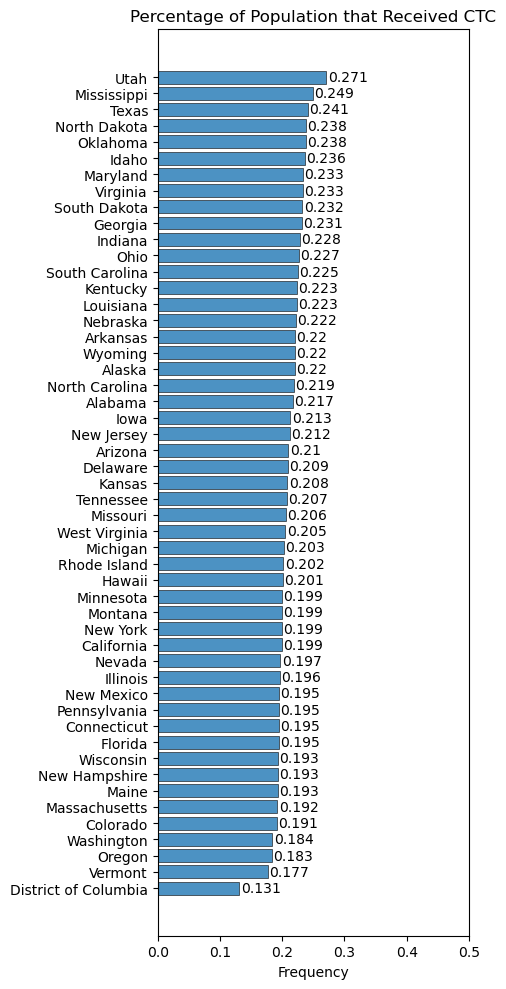

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(5, 10))
p1 = ax.barh(subset['NAME'], subset['Weighted_PCT_CTC'], edgecolor='black', linewidth=.5, alpha=.8, color="tab:blue")
ax.bar_label(p1, label_type='edge', padding=1.1, fmt="%g")
ax.set_xlim(0, 0.5)
ax.set_title("Percentage of Population that Received CTC")
ax.set_xlabel("Frequency")
fig.tight_layout()

In [9]:
ctc_cols = pd.Series(df.columns)[pd.Series(df.columns).str.contains("CTC")].values

In [10]:
received_ctc = df.query("Received_CTC == 1")

In [11]:
received_ctc['CTC_USE_Text'] = received_ctc['CTC_USE'].replace({2: "Mostly Save", 1: "Mostly Spend", 3: "Mostly Pay off Debt", -99: "No Answer"})

C:\Users\peteramerkhanian\AppData\Local\Temp\ipykernel_10356\3438109547.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  received_ctc['CTC_USE_Text'] = received_ctc['CTC_USE'].replace({2: "Mostly Save", 1: "Mostly Spend", 3: "Mostly Pay off Debt", -99: "No Answer"})


In [12]:
all_people = received_ctc["HWEIGHT"].sum()

In [13]:
value_count_table = round(received_ctc.groupby('CTC_USE_Text')["HWEIGHT"].sum() / all_people, 3).sort_values()

In [14]:
food_insecure_recipients = received_ctc.query("Food_Insecurity == 1")

In [15]:
spending = pd.Series(ctc_cols)[pd.Series(ctc_cols).str.contains("SPND")]

In [16]:
received_ctc[spending] = received_ctc[spending].replace({-99: 0})

C:\Users\peteramerkhanian\AppData\Local\Temp\ipykernel_10356\2404924626.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  received_ctc[spending] = received_ctc[spending].replace({-99: 0})


In [17]:
for col in spending:
    received_ctc[col] = received_ctc['HWEIGHT'] * received_ctc[col]

C:\Users\peteramerkhanian\AppData\Local\Temp\ipykernel_10356\3615485834.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  received_ctc[col] = received_ctc['HWEIGHT'] * received_ctc[col]


In [18]:
spending_dict = {
    'CTCSPND1': "Food",
    'CTCSPND2': "Clothing",
    'CTCSPND3': "Childcare",
    'CTCSPND4': "School Supplies",
    'CTCSPND5': "School Tuition",
    'CTCSPND6': "Tutoring for Child",
    'CTCSPND7': "After-school Programs",
    'CTCSPND8': "After-school Programs",
    'CTCSPND9': "Recreational Goods",
    'CTCSPND10': "Rent Payment",
    'CTCSPND11': "Mortgage Payment",
    'CTCSPND12': "Utilities Payment",
    'CTCSPND13': "Vehicle Payment",
    'CTCSPND14': "Pay Down Debt",
    'CTCSPND15': "Charitable Donations",
    'CTCSPND16': "Savings/Investments",
    'CTCSPND17': "Other"
}

In [19]:
ctc_uses = received_ctc[spending].sum() / received_ctc[spending].sum().sum()

In [20]:
ctc_uses = round(ctc_uses.sort_values(ascending=True), 3)
ctc_uses.index = pd.Series(ctc_uses.index).replace(spending_dict).values

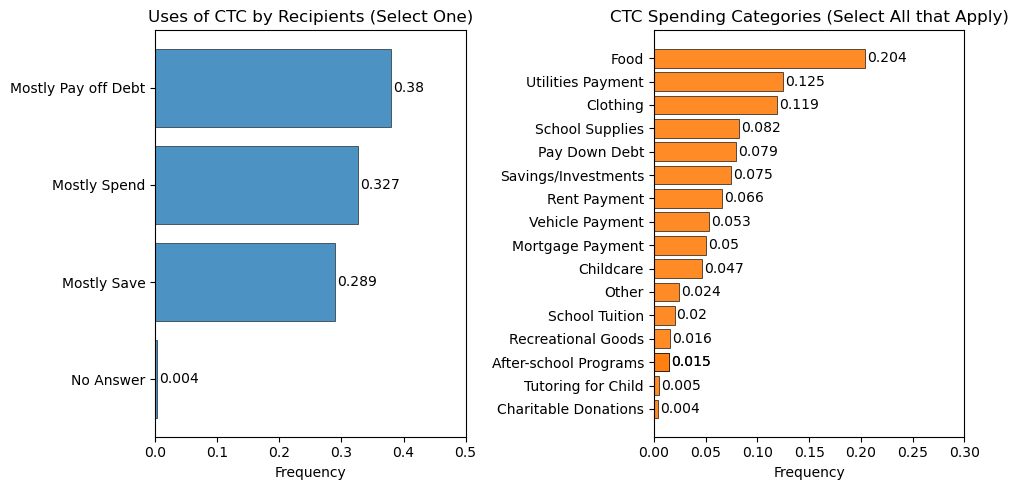

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
p1 = axes[0].barh(value_count_table.index, value_count_table.values, edgecolor='black', linewidth=.5, alpha=.8, color="tab:blue")
axes[0].bar_label(p1, label_type='edge', padding=1.5, fmt="%g")
axes[0].set_xlim(0, 0.5)
axes[0].set_title("Uses of CTC by Recipients (Select One)")
axes[0].set_xlabel("Frequency");

p1 = axes[1].barh(ctc_uses.index, ctc_uses.values, edgecolor='black', linewidth=.5, alpha=.9, color="tab:orange")
axes[1].bar_label(p1, label_type='edge', padding=1.5, fmt="%g")
axes[1].set_xlim(0, 0.3)
axes[1].set_xlabel("Frequency")
axes[1].set_title("CTC Spending Categories (Select All that Apply)")

fig.tight_layout()
fig.savefig("figures/ctc_recipient_spending.png", dpi=300, bbox_inches = "tight")

In [22]:
spending_vars = " + ".join(spending.values)

In [23]:
formula = f"Food_Insecurity ~ {spending_vars}"
spending_model = (
    sm.WLS.from_formula(
        formula,
        data=received_ctc,
        weights=received_ctc['Household_Weight']
    )).fit()


In [24]:
spending_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:        Food_Insecurity   R-squared:                       0.038
Model:                            WLS   Adj. R-squared:                  0.038
Method:                 Least Squares   F-statistic:                     161.7
Date:                Thu, 08 Dec 2022   Prob (F-statistic):               0.00
Time:                        11:28:27   Log-Likelihood:                -30652.
No. Observations:               68867   AIC:                         6.134e+04
Df Residuals:                   68849   BIC:                         6.150e+04
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0724      0.001     56.992      0.000       0.070       0.075
CTCSPND1    4.066e-06   2.05e-07     19.862      0.000    3.67e-06    4.47e-06
CTCSPND2   -2.508e-06   2.15e-07    -11.673      0.000   -2.93e-06   -2.09e-06
CTCSPND3    3.688e-07   3.76e-07      0.980      0.327   -3.69e-07    1.11e-06
CTCSPND4    1.314e-06   2.38e-07      5.523      0.000    8.48e-07    1.78e-06
CTCSPND5   -3.524e-06   4.46e-07     -7.902      0.000    -4.4e-06   -2.65e-06
CTCSPND6   -1.799e-06   8.53e-07     -2.108      0.035   -3.47e-06   -1.27e-07
CTCSPND7    6.391e-06   6.34e-07     10.084      0.000    5.15e-06    7.63e-06
CTCSPND8    7.125e-06    4.6e-07     15.495      0.000    6.22e-06    8.03e-06
CTCSPND9   -1.615e-06   5.46e-07     -2.957      0.003   -2.68e-06   -5.45e-07
CTCSPND10   4.044e-06   2.25e-07     17.949      0.000     3.6e-06    4.49e-06
CTCSPND11  -1.138e-06   3.39e-07     -3.353      0.001    -1.8e-06   -4.73e-07
CTCSPND12   6.046e-07   2.24e-07      2.699      0.007    1.66e-07    1.04e-06
CTCSPND13   2.565e-06   2.67e-07      9.603      0.000    2.04e-06    3.09e-06
CTCSPND14   -9.63e-07   2.27e-07     -4.246      0.000   -1.41e-06   -5.18e-07
CTCSPND15  -1.261e-06   9.03e-07     -1.397      0.162   -3.03e-06    5.08e-07
CTCSPND16  -3.271e-06    2.8e-07    -11.675      0.000   -3.82e-06   -2.72e-06
CTCSPND17   3.523e-06   4.48e-07      7.863      0.000    2.64e-06     4.4e-06
==============================================================================
Omnibus:                    65416.918   Durbin-Watson:                   1.987
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          2940614.114
Skew:                           4.678   Prob(JB):                         0.00
Kurtosis:                      33.615   Cond. No.                     1.67e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.67e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""